In [1]:
import numpy as np
#import xgboost as xgb
import pandas as pd
import math
import os
import sys
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error 
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt 

In [2]:
dtype = {'Semana': np.uint8, 
         'Agencia_ID': np.uint16, 
         'Canal_ID': np.uint8,
         'Ruta_SAK': np.uint16, 
         'Cliente_ID': np.uint32, 
         'Producto_ID': np.uint16,
         #'Venta_uni_hoy':np.uint16,
         #'Venta_hoy':np.float32,
         #'Dev_uni_proxima':np.float32,
         'Demanda_uni_equil': np.uint16}

filename='/Users/tatianazabrodina/Desktop/мага/2021_2022/Анализ данных и машинное обучение/лаба2/grupo-bimbo-inventory-demand/train.csv'

%time df_train = pd.read_csv(filename, usecols=dtype.keys(), dtype=dtype)
df_train.head()

CPU times: user 45.5 s, sys: 5.53 s, total: 51 s
Wall time: 54.3 s


,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Demanda_uni_equil
0,3,1110,7,3301,15766,1212,3
1,3,1110,7,3301,15766,1216,4
2,3,1110,7,3301,15766,1238,4
3,3,1110,7,3301,15766,1240,4
4,3,1110,7,3301,15766,1242,3


In [99]:
df=df_train.sample(frac=0.0013).reset_index(drop=True)
df.shape

(96435, 7)

In [4]:
filename='/Users/tatianazabrodina/Desktop/мага/2021_2022/Анализ данных и машинное обучение/лаба2/grupo-bimbo-inventory-demand/town_state.csv'

%time df_town_state_n = pd.read_csv(filename)
df_town_state_n.head()

CPU times: user 4.2 ms, sys: 23.8 ms, total: 28 ms
Wall time: 29 ms


,Agencia_ID,Town,State
0,1110,2008 AG. LAGO FILT,"MÉXICO, D.F."
1,1111,2002 AG. AZCAPOTZALCO,"MÉXICO, D.F."
2,1112,2004 AG. CUAUTITLAN,ESTADO DE MÉXICO
3,1113,2008 AG. LAGO FILT,"MÉXICO, D.F."
4,1114,2029 AG.IZTAPALAPA 2,"MÉXICO, D.F."


In [100]:
df=df.merge(df_town_state_n, on='Agencia_ID')
df.head()

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Demanda_uni_equil,Town,State
0,6,1340,1,2070,681114,37058,4,2275 TEPIC BIMBO,NAYARIT
1,8,1340,1,2052,251775,37058,4,2275 TEPIC BIMBO,NAYARIT
2,8,1340,1,2154,1696860,43058,3,2275 TEPIC BIMBO,NAYARIT
3,5,1340,1,1171,323033,1232,2,2275 TEPIC BIMBO,NAYARIT
4,6,1340,1,1163,4804965,48417,5,2275 TEPIC BIMBO,NAYARIT


In [101]:
df[['Town','State']].describe()

,Town,State
count,96435,96435
unique,256,33
top,2017 AG. SANTA CLARA,ESTADO DE MÉXICO
freq,1160,14171


In [102]:
from category_encoders import BinaryEncoder

In [103]:
x_train = df['State']
y_train = df['Demanda_uni_equil']

# create an encoder object - it will apply on all strings columns.
binary = BinaryEncoder()

# fit and transform to get encoded data.
df = pd.concat([df,binary.fit_transform(x_train, y_train)], axis=1).drop('State',axis=1)

In [104]:
df.head()

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Demanda_uni_equil,Town,State_0,State_1,State_2,State_3,State_4,State_5
0,6,1340,1,2070,681114,37058,4,2275 TEPIC BIMBO,0,0,0,0,0,1
1,8,1340,1,2052,251775,37058,4,2275 TEPIC BIMBO,0,0,0,0,0,1
2,8,1340,1,2154,1696860,43058,3,2275 TEPIC BIMBO,0,0,0,0,0,1
3,5,1340,1,1171,323033,1232,2,2275 TEPIC BIMBO,0,0,0,0,0,1
4,6,1340,1,1163,4804965,48417,5,2275 TEPIC BIMBO,0,0,0,0,0,1


In [107]:
df_cop=df.copy()

In [108]:
X=df_cop.drop('Demanda_uni_equil', axis=1)
y=df.Demanda_uni_equil

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=45)

In [111]:
from category_encoders import LeaveOneOutEncoder

In [112]:
encoder = LeaveOneOutEncoder(return_df=True)

# fit and transform the data.
X_train=encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test, y_test)

In [117]:
reg_best=RandomForestRegressor(n_estimators=500, max_depth=20,min_samples_split=2)
reg_best.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [118]:
def rmsle(y_true, y_pred):
    res = math.sqrt(mean_squared_log_error(y_true, y_pred))
    return res

In [119]:
rmsle(reg_best.predict(X_test),y_test)

0.6681769342558895

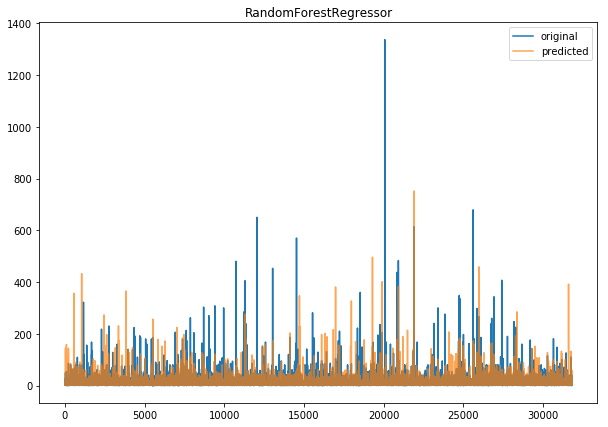

In [121]:
import matplotlib.pyplot as plt 
fig = plt.figure(figsize=(10,7))
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, reg_best.predict(X_test), label="predicted", alpha=0.7)
plt.title('RandomForestRegressor')
plt.legend()
plt.show()

In [122]:
score_rmsle = make_scorer(rmsle, greater_is_better=False)

parameters = {
    'n_estimators':[400,500],
    'max_depth':[10,20]}

reg=RandomForestRegressor(n_jobs=-1)
clf = GridSearchCV(reg, parameters,scoring=score_rmsle, cv=3, verbose=2)

clf.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] max_depth=10, n_estimators=400 ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................... max_depth=10, n_estimators=400, total=  21.5s
[CV] max_depth=10, n_estimators=400 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.9s remaining:    0.0s


[CV] ................... max_depth=10, n_estimators=400, total=  19.4s
[CV] max_depth=10, n_estimators=400 ..................................
[CV] ................... max_depth=10, n_estimators=400, total=  17.9s
[CV] max_depth=10, n_estimators=500 ..................................
[CV] ................... max_depth=10, n_estimators=500, total=  20.1s
[CV] max_depth=10, n_estimators=500 ..................................
[CV] ................... max_depth=10, n_estimators=500, total=  24.9s
[CV] max_depth=10, n_estimators=500 ..................................
[CV] ................... max_depth=10, n_estimators=500, total=  25.9s
[CV] max_depth=20, n_estimators=400 ..................................
[CV] ................... max_depth=20, n_estimators=400, total=  34.9s
[CV] max_depth=20, n_estimators=400 ..................................
[CV] ................... max_depth=20, n_estimators=400, total=  34.2s
[CV] max_depth=20, n_estimators=400 ..................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  6.1min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [400, 500], 'max_depth': [10, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(rmsle, greater_is_better=False), verbose=2)

In [123]:
clf.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [124]:
np.abs(clf.best_score_)

0.6905670911865719

In [125]:
clf.score(X_train, y_train)

-0.4420311183398845

In [126]:
rmsle(clf.predict(X_test),y_test)

0.6683566921736335

In [127]:
reg_best1=RandomForestRegressor(n_estimators=clf.best_params_['n_estimators'], max_depth=clf.best_params_['max_depth'])
reg_best1.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [129]:
rmsle(reg_best1.predict(X_test),y_test)

0.6684063707875759

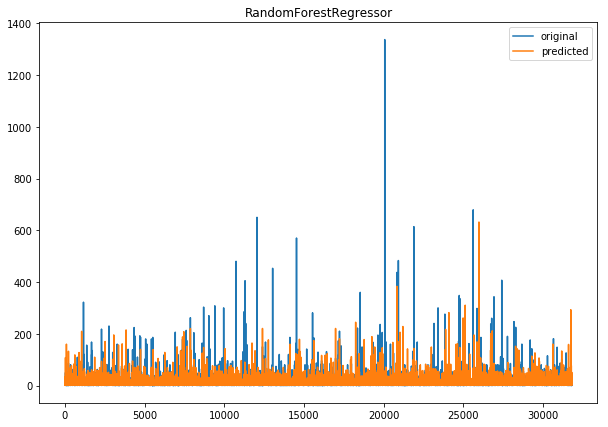

In [130]:
import matplotlib.pyplot as plt 
fig = plt.figure(figsize=(10,7))
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, reg_best2.predict(X_test), label="predicted")
plt.title('RandomForestRegressor')
plt.legend()
plt.show()

In [ ]:
X_train.to_csv('X_train.csv', index = False)
y_train.to_csv('y_train.csv', index = False)
X_test.to_csv('X_test.csv', index = False)
y_test.to_csv('y_test.csv', index = False)